In [1]:
from matplotlib import pyplot as plt, rcParams, animation
import scipy, seaborn as sns, matplotlib
from scipy.cluster import hierarchy as hc
matplotlib.rc('animation', html='html5')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=5, linewidth=110, suppress=True)
import warnings
warnings.filterwarnings("ignore")

import FA
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
import os, math, pandas as pd, pickle, datetime, time
from pandas_summary import DataFrameSummary
from IPython.display import HTML, display
from treeinterpreter import treeinterpreter as ti
from waterfall_chart import plot as waterfall
from pdpbox import pdp

In [2]:
from sklearn import metrics, ensemble, preprocessing
from sklearn.ensemble import _forest as forest
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer as Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge

---

In [3]:
df = pd.read_pickle('df_updated')
df.head(2)

,CBOEDayBefore,CBOE,industry_0,industry_Automobiles & Components,industry_Banks,industry_Capital Goods,industry_Commercial & Professional Services,industry_Consumer Discretionary Distribution & Retail,industry_Consumer Durables & Apparel,industry_Consumer Services,...,sent44,sent46,sent47,sent48,sent49,sent50,sent51,sent52,sent53,Mkt_Reaction_Percent
0,24.78,21.55,0,0,0,0,0,0,0,0,...,0.0,0.0,-0.000091,0.0,0.0,0.0,0.0,0.0,0.0,0.004659
1,24.78,21.55,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.097452


#### Transforming dataset 

In [4]:
df_new, y, nas = FA.proc_df(df=df, y_fld='Mkt_Reaction_Percent')
df_new.shape

(1950, 128)

---

### I. Random forest

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_new, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape

((1462, 128), (1462,))

In [6]:
param_grid = {
    'n_estimators': [50, 70, 100],
    'max_depth': [7, 9],
    'max_features': ['sqrt', 0.5],
    'min_samples_leaf': [3, 5]
}

#Perform cross-validation
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

#Select the best hyperparameters
best_params = grid_search.best_params_

#Train the model with the best hyperparameters
rf_best = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
rf_best.fit(X_train, y_train)

#Evaluate the model
y_pred = rf_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test Mean Squared Error: {:.7f}".format(mse))

Test Mean Squared Error: 0.0042597


In [7]:
y_pred_trn = rf_best.predict(X_train)
mse_trn = mean_squared_error(y_train, y_pred_trn)
print("Train Mean Squared Error: {:.7f}".format(mse_trn))

Train Mean Squared Error: 0.0028375


In [8]:
def rmse(pred,y): return math.sqrt(((pred-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_test), y_test),
                r2_score(y_train, m.predict(X_train)), r2_score(y_test, m.predict(X_test))]
    res = np.round(res,5)
    print(f'RMSE train: {res[0]}, RMSE test: {res[1]}, R2 train: {res[2]}, R2 test: {res[3]}')

In [9]:
print_score(rf_best)

RMSE train: 0.05327, RMSE test: 0.06527, R2 train: 0.38966, R2 test: 0.01921


In [10]:
y_std = y.std()
print(f"Std of y: {y_std}, Variance of y: {np.power(y_std,2)}")

Std of y: 0.06762044673371836, Variance of y: 0.004572524816467642


In [11]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 9, 'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 100}


### Feature importances

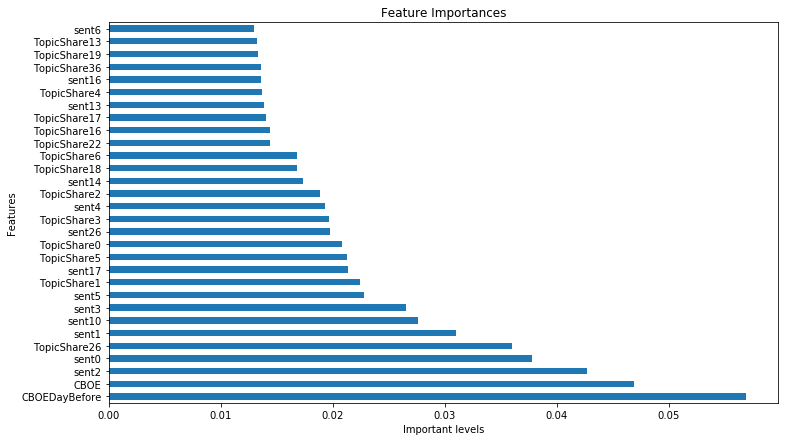

In [12]:
fi = FA.rf_feat_importance(rf_best, df_new)
FA.plot_fi(fi[:30])

In [17]:
mapping = {
    0: "Everything else",
    1: "Diverse",
    2: "Margin and Sales Changes",
    3: "Inflation",
    4: "Regulation adherence (Gaap)",
    5: "Pricing",
    6: "Capital Position/Structure",
    7: "Sales Volume & Demand",
    8: "Organic Growth & Sales",
    9: "Housing/Generations",
    10: "EBIT & EBITDA",
    11: "Loans",
    12: "Healthcare",
    13: "Exchange Rates",
    14: "EPS",
    15: "Quarterly Comparison",
    16: "Ukraine War",
    17: "Revenue",
    18: "Supply",
    19: "Balance Sheet & Liquidity",
    20: "Customer Service & Relationship",
    21: "Sustainability",
    22: "Digital Transformation",
    23: "Fossil Fuels",
    24: "Growth Aspects",
    25: "Demand & Volatility",
    26: "Headwinds",
    27: "Bookings",
    28: "Brand",
    29: "Airline",
    30: "Insurance",
    31: "US Domestic",
    32: "Energy/Fuels",
    33: "Pride",
    34: "Y-o-Y Developments",
    35: "SGA",
    36: "Volume",
    37: "Pipeline",
    38: "Omikron Variant",
    39: "ESG",
    40: "Cloud",
    41: "Electric Technologies",
    42: "Beverages",
    43: "Wireless Infrastructure",
    44: "CapEx",
    45: "M&A",
    46: "Leverage",
    47: "Multiplier x",
    48: "Deposits",
    49: "PreTax Reports",
    50: "Hotels & Gastronomy",
    51: "Highlights",
    52: "NOI",
    53: "Backlog"
}

In [64]:
import re 

def add_description(name):
    match = re.search(r"^(TopicShare|sent)(\d+)$", name)
    if match:
        prefix = match.group(1)
        number = int(match.group(2))
        suffix = mapping.get(number)
        if suffix:
            return f"{prefix}{number}_{suffix}"
    return name

In [13]:
to_keep = fi[fi.imp>0.003].cols
len(to_keep) 

66

In [14]:
df_keep = df_new[to_keep]
df_keep.shape

(1950, 66)

#### Retrain the model with the reduced number of features

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_keep, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape

((1462, 66), (1462,))

In [25]:
m = RandomForestRegressor(n_estimators=100, max_depth=9, max_features=0.5,
                          min_samples_leaf=5, n_jobs=-1)
m.fit(X_train, y_train)
#Evaluate the model
y_pred = m.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(" Test Mean Squared Error: {:.7f}".format(mse))

 Test Mean Squared Error: 0.0042811


In [26]:
y_pred_trn = m.predict(X_train)
mse_trn = mean_squared_error(y_train, y_pred_trn)
print("Train Mean Squared Error: {:.7f}".format(mse_trn))

Train Mean Squared Error: 0.0028099


In [27]:
print_score(m) 

RMSE train: 0.05301, RMSE test: 0.06543, R2 train: 0.3956, R2 test: 0.01428


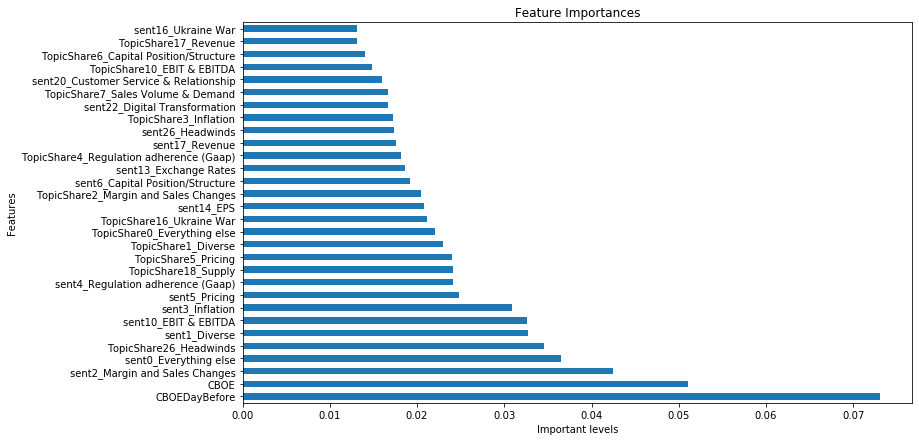

In [30]:
fi = FA.rf_feat_importance(m, df_keep)
fi['full_description'] = fi['cols'].apply(add_description)
FA.plot_fi(fi[:30])

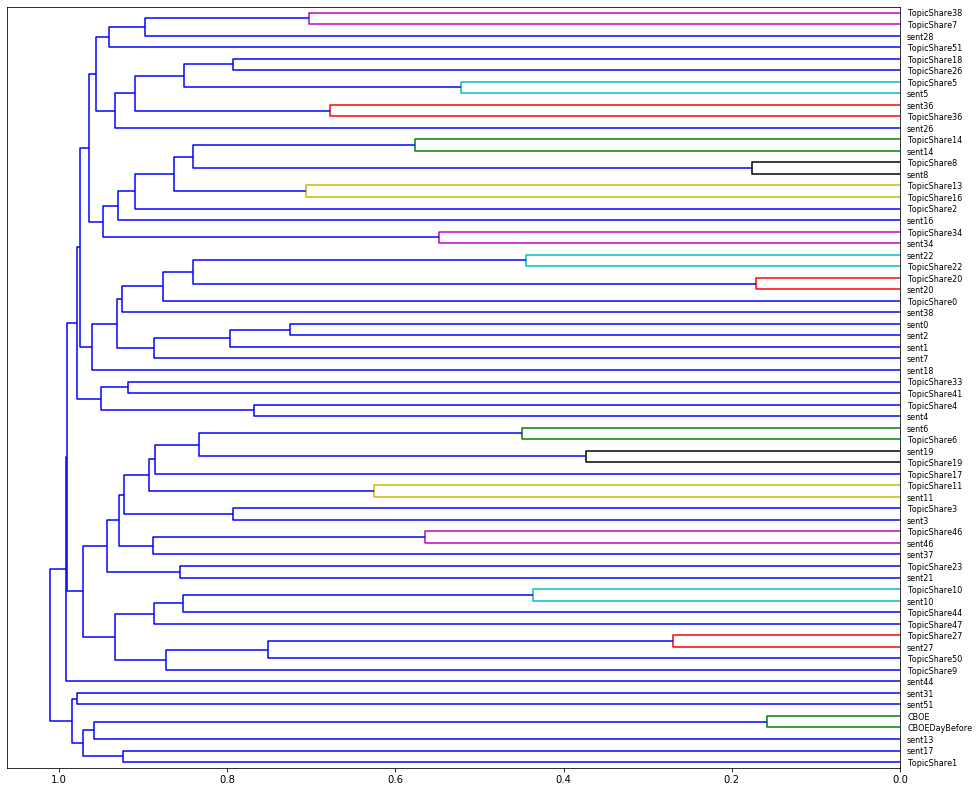

In [31]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,14))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, 
                           orientation='left', leaf_font_size=8)

In [32]:
to_drop = ['CBOE', 'TopicShare20', 'TopicShare8']
df_keep.drop(to_drop, axis=1, inplace=True)

#### Retrain the model with the reduced number of features

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_keep, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape

((1462, 63), (1462,))

In [38]:
m = RandomForestRegressor(n_estimators=100, max_depth=9, max_features=0.5,
                          min_samples_leaf=5, n_jobs=-1)
m.fit(X_train, y_train)
#Evaluate the model
y_pred = m.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test Mean Squared Error: {:.7f}".format(mse))

Test Mean Squared Error: 0.0042629


In [39]:
y_pred_trn = m.predict(X_train)
mse_trn = mean_squared_error(y_train, y_pred_trn)
print("Train Mean Squared Error: {:.7f}".format(mse_trn))

Train Mean Squared Error: 0.0029007


In [40]:
print_score(m) 

RMSE train: 0.05386, RMSE test: 0.06529, R2 train: 0.37606, R2 test: 0.01847


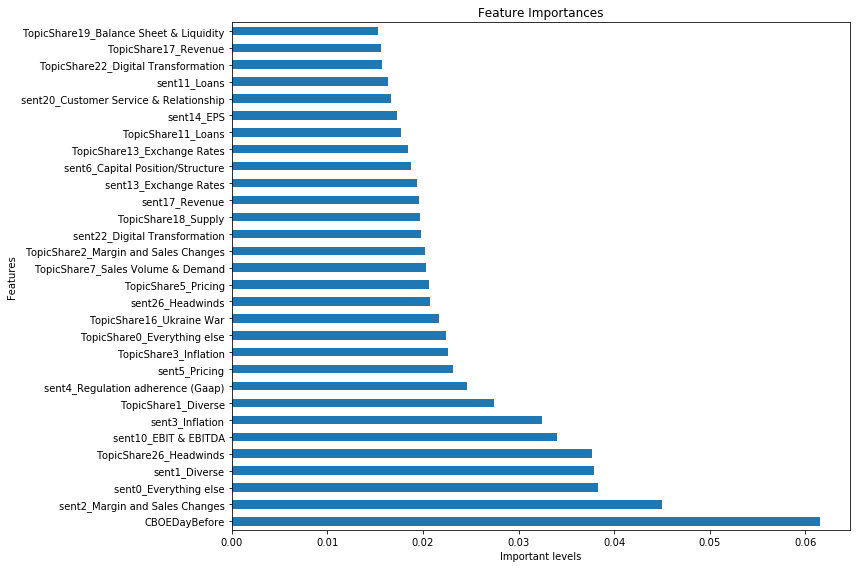

In [63]:
fi = FA.rf_feat_importance(m, df_keep)
fi['full_description'] = fi['cols'].apply(add_description)
FA.plot_fi(fi[:30])

#### Prediction confidence

In [42]:
preds = np.stack([tree.predict(X_test) for tree in m.estimators_])
preds.shape

(100, 488)

In [43]:
preds_std = preds.std(0)
preds_std.shape

(488,)

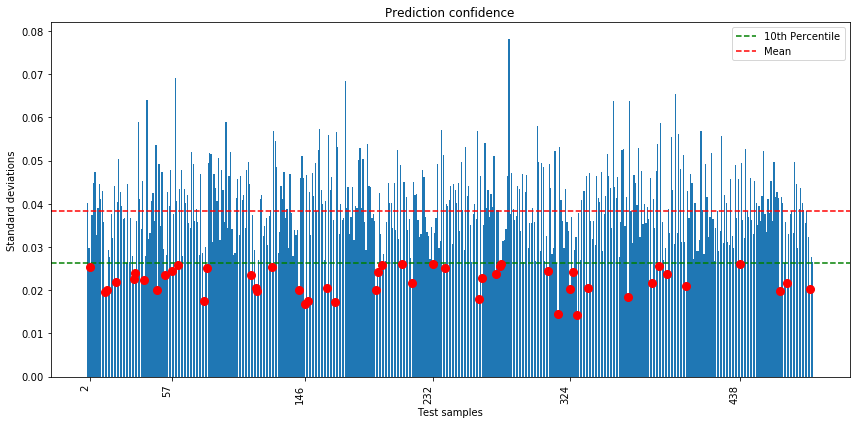

In [55]:
plt.figure(figsize=(12, 6))  
plt.bar(range(len(preds_std)), preds_std)

# Calculate the 10th percentile
percentile_10 = np.percentile(preds_std, 10)
# Add a line for the 10th percentile value
plt.axhline(percentile_10, color='g', linestyle='--', label='10th Percentile')

# Calculate the mean
mean_value = np.mean(preds_std)
# Add a line for the mean value
plt.axhline(mean_value, color='r', linestyle='--', label='Mean')

# Define the desired x-axis tick positions and labels
filtered_ticks = [tick for tick, val in enumerate(preds_std) if val < percentile_10]
step = max(1, int(len(filtered_ticks) / 5))  # Adjust the step size for the desired number of ticks
x_ticks = np.array(filtered_ticks[::step])
x_tick_labels = [str(tick) if tick in filtered_ticks else '' for tick in range(len(preds_std))]

# Set the x-axis tick positions and labels
plt.xticks(x_ticks, [x_tick_labels[tick] for tick in x_ticks], rotation=90, ha='right')

# Set the chart title and labels
plt.title('Prediction confidence')
plt.ylabel('Standard deviations')
plt.xlabel('Test samples')

# Add circles for values below the 10th percentile
for i, val in enumerate(preds_std):
    if val < percentile_10:
        plt.plot(i, val, 'ro', markersize=8)

plt.legend()
plt.tight_layout()
plt.savefig('prediction_chart.png')

The higher the confidence, the lower the standard deviation

#### Partial dependence

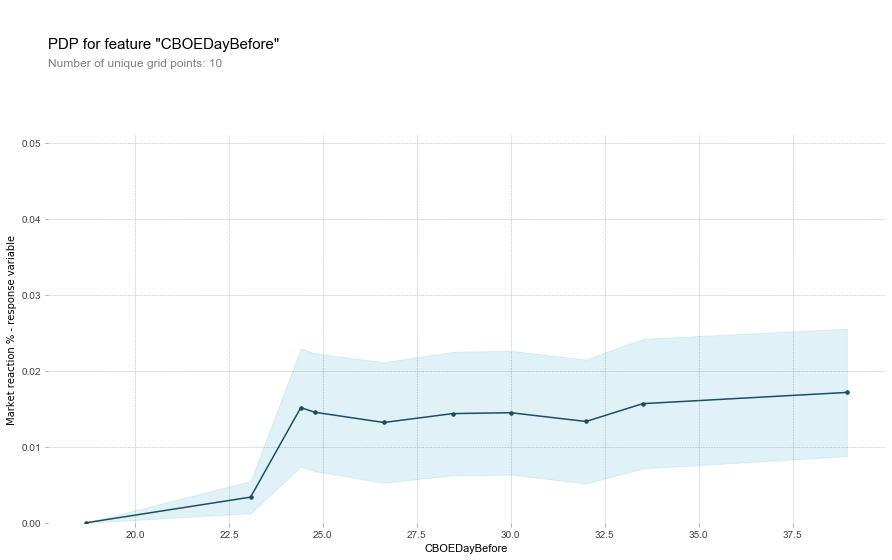

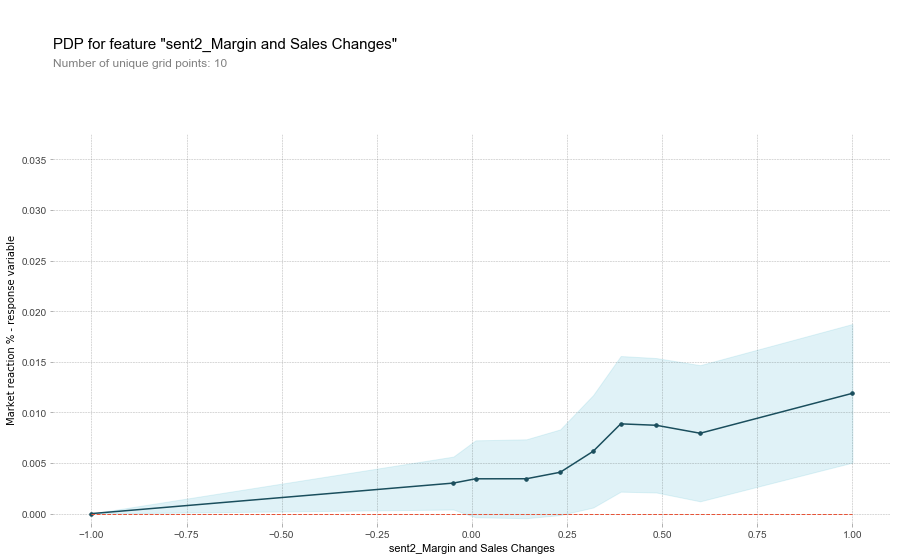

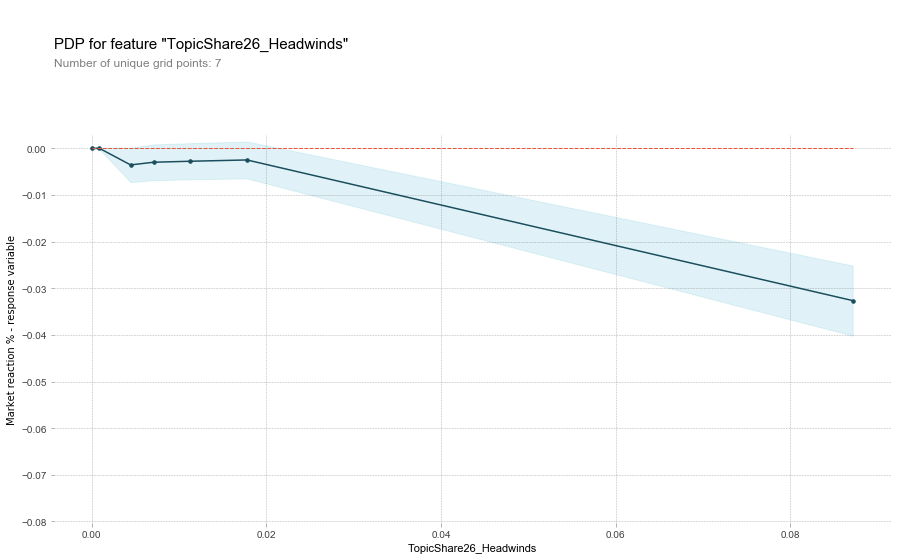

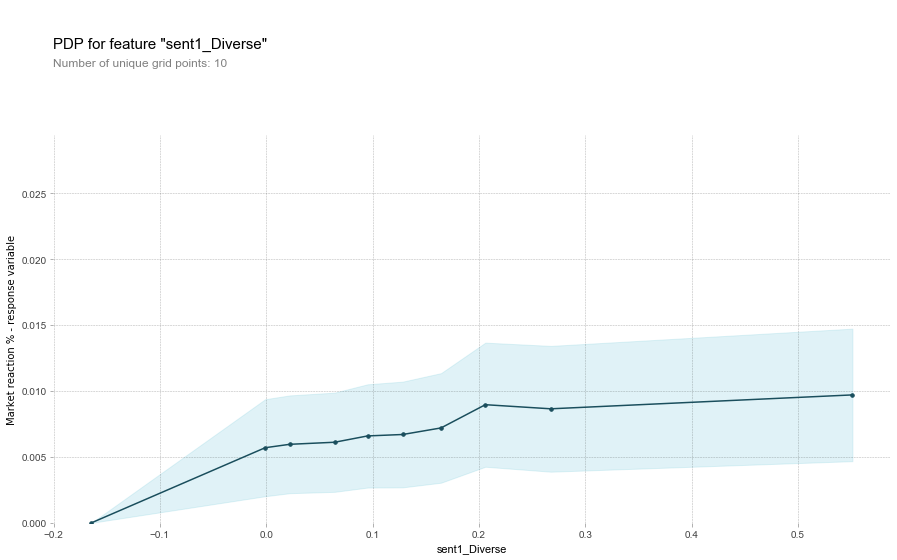

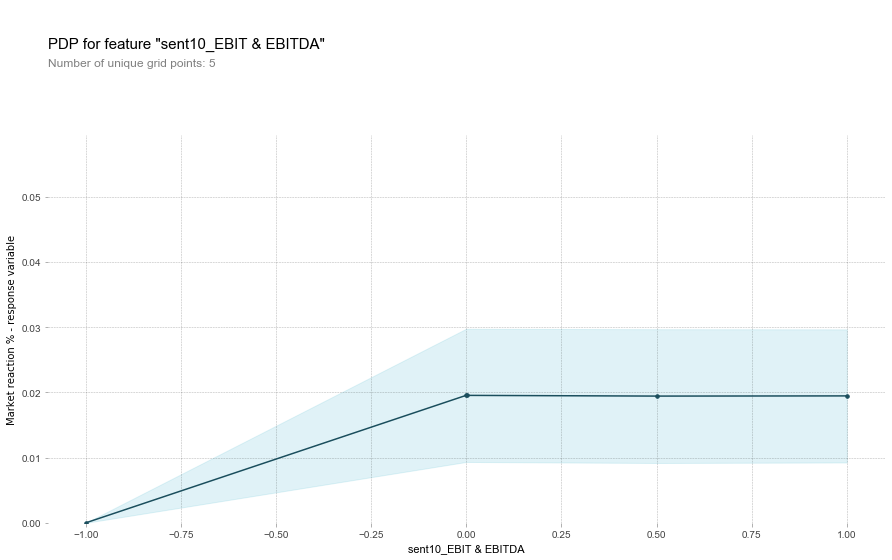

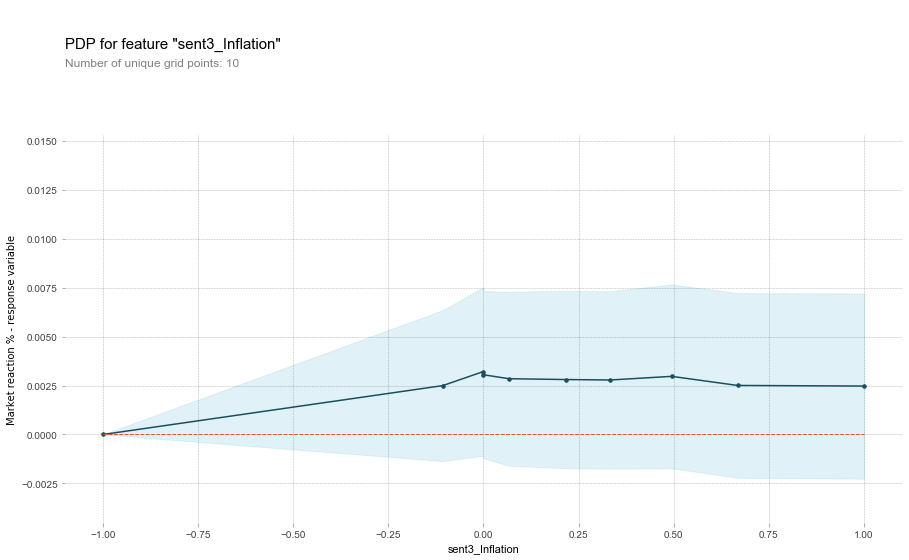

In [56]:
importances = fi['imp']
top_feature_indices = importances.argsort()[-7:][::-1]
top_feature_names = [X_train.columns[i] for i in top_feature_indices]
top_feature_names = [X_train.columns[i] for i in top_feature_indices if X_train.columns[i] != 'sent0']

def get_feature_description(feature_name):
    match = re.search(r"^(TopicShare|sent)(\d+)$", feature_name)
    if match:
        prefix = match.group(1)
        number = int(match.group(2))
        suffix = mapping.get(number)
        if suffix:
            return f"{prefix}{number}_{suffix}"
    return feature_name

for feature_name in top_feature_names:
    pdp_feature = pdp.pdp_isolate(model=m, dataset=X_train, model_features=X_train.columns, feature=feature_name)
    pdp.pdp_plot(pdp_feature, get_feature_description(feature_name))  # Use the mapped description as chart title
    plt.ylabel('Market reaction % - response variable')
    plt.tight_layout()
    plt.savefig('pdp_{}.png'.format(feature_name))
    plt.show()

In [61]:
col = fi['cols'].tolist()
col.append('Mkt_Reaction_Percent')
df_for_LR = df[col]
df_for_LR.shape

(1950, 64)

In [48]:
df_for_LR.to_pickle('df_for_LR')

---

### II. OLS, Lasso, and Ridge

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df_new, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape

((1462, 128), (1462,))

#### 1. OLS

In [62]:
m = LinearRegression().fit(X_train, y_train)
m.score(X_test, y_test)

-0.02353538743594763

In [63]:
mse = mean_squared_error(y_train, m.predict(X_train))
print("Train Mean Squared Error: {:.7f}".format(mse))

Train Mean Squared Error: 0.0040592


In [64]:
y_pred = m.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test Mean Squared Error: {:.7f}".format(mse))

Test Mean Squared Error: 0.0044453


In [65]:
model = LinearRegression().fit(X_train, y_train)
train_predictions = model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)
print("Training MSE:", train_mse)

# Make predictions on the testing set
test_predictions = model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)

print("Testing MSE:", test_mse)

Training MSE: 0.00405923314107462
Testing MSE: 0.004445342745621275


In [66]:
print_score(m)

RMSE train: 0.06371, RMSE test: 0.06667, R2 train: 0.12687, R2 test: -0.02354


#### 2. Lasso

In [67]:
alpha_values = [0.001, 0.01, 1.0, 10] 
param_grid = {'alpha': alpha_values}
scoring_metric = 'neg_mean_squared_error'  # negative MSE for maximization purpose)

# Lasso and Cross-Validation
lasso = Lasso()
cv = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-folds 

# Grid Search
grid_search = GridSearchCV(lasso, param_grid, cv=cv, scoring=scoring_metric)
grid_search.fit(X_train, y_train)  

# Retrieve Results
best_alpha = grid_search.best_params_['alpha']
best_score = -grid_search.best_score_  # Negative of negative MSE

# Evaluate on Test Set
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train, y_train)  
y_pred = lasso_best.predict(X_test)  # Make predictions on the test set
test_mse = mean_squared_error(y_test, y_pred)

print("Best alpha:", best_alpha)
print("Train MSE: ", mean_squared_error(y_train, lasso_best.predict(X_train)))
print("Test MSE:", test_mse)

Best alpha: 0.001
Train MSE:  0.00443860673112397
Test MSE: 0.004319198895010817


In [68]:
print_score(lasso_best)

RMSE train: 0.06662, RMSE test: 0.06572, R2 train: 0.04527, R2 test: 0.00551


#### 3. Ridge

In [69]:
alpha_values = [0.1, 1.0, 10.0, 100, 1000]  
param_grid = {'alpha': alpha_values}
scoring_metric = 'neg_mean_squared_error' 

# Ridge and Cross-Validation
ridge = Ridge()
cv = KFold(n_splits=5, shuffle=True, random_state=42)  

# Grid Search
grid_search = GridSearchCV(ridge, param_grid, cv=cv, scoring=scoring_metric)
grid_search.fit(X_train, y_train) 

# Retrieve Results
best_alpha = grid_search.best_params_['alpha']
best_score = -grid_search.best_score_  

# Evaluate on Test Set
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)  
y_pred = ridge_best.predict(X_test) 
test_mse = mean_squared_error(y_test, y_pred)

print("Best alpha:", best_alpha)
print("Train MSE: ", mean_squared_error(y_train, ridge_best.predict(X_train)))
print("Test MSE:", test_mse)

Best alpha: 1000
Train MSE:  0.004439085822334014
Test MSE: 0.0043215181232622865


In [70]:
print_score(ridge_best)

RMSE train: 0.06663, RMSE test: 0.06574, R2 train: 0.04517, R2 test: 0.00498


---

---

---

---

---

---

---